## Exploration for Claim 2a: ##
Let's take a look at Sale Price vs Sq Ft, then add a porch or deck.
How does that change things?

### Null hypothesis: There is no relationship between sale price and the additional variables of Sq Ft and outdoor space

### Alternative hypothesis: There is no relationship between sale price and the additional variables of Sq Ft and outdoor space



### Make necessary imports

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.stats.api as sms
from sklearn.linear_model import LinearRegression

%matplotlib inline
plt.style.use('ggplot')

#from ltests import model

### Import our combined csv into a DataFrame

In [2]:
raw = pd.read_csv('../../data/master.csv', low_memory=False, dtype={'id': object})


In [3]:
#how many entries are there?
raw.shape[0]

62039

### SalePrice will be our target variable, so lets' set that as the index

In [4]:
#set the target to column index 0
cols = list(raw.columns)
cols = [cols[3]] + cols[:3] + cols[4:]
raw = raw[cols]
raw.head()

,SalePrice,id,ExciseTaxNbr,DocumentDate,RecordingNbr,Volume,Page,PlatNbr,PlatType,PlatLot,...,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,footprint
0,9796500,0000200042,3003343,08/02/2019,20190805001366,,,,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0001000004,3003032,06/26/2019,20190802000413,,,,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,485500,0001000042,3018323,10/29/2019,20191031001228,,,,,,...,0.0,0.0,2016.0,0.0,0.0,0.0,0.0,3.0,0.0,0.238254
3,0,0001000047,2994317,05/15/2019,20190618001163,,,,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6050000,0001000056,3012411,09/27/2019,20190927001106,,,,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### We would like to select only those entries that have a sale price greater than 0

In [5]:
raw = raw[raw.SalePrice > 0]

#How many entries are left?
raw.shape[0]

42214

### Now we select the sales with the proper PropertyType codes
The following is interest to us:
 - 11: Household, single family units

These are not because they don't help us answer our questions about homeownership

 - 12: Multiple family residence (Residential, 2-4 units)
 - 13: Multiple family residence (Residential, 5+ units)
 - 14: Residential condominiums
  
*These codes can be found in the Lookup.zip file located at*

https://info.kingcounty.gov/assessor/DataDownload/default.aspx 

In [6]:
proptypes = [11]

df = raw[raw.PropertyType.isin(proptypes)]

#How many entries are left now?
df.shape[0]


19264

### Let's look at houses that have any porch or deck (aka OutdoorSpace)

### Generate our first simple model of Sale Price vs Sq Ft Living Space

In [7]:
fsm_df = df[["SalePrice", "SqFtTotLiving"]].copy()
fsm_df.dropna(inplace=True)
formula = 'SalePrice ~ SqFtTotLiving'
fsm = ols(formula=formula, data=fsm_df).fit()

What kind of p-value have we got?

In [8]:
fsm.pvalues

Intercept        0.052098
SqFtTotLiving    0.000000
dtype: float64

Well that was unexpected.

##### Let's look at the summary

In [9]:
fsm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                 1.187e+04
Date:                Fri, 19 Jun 2020   Prob (F-statistic):               0.00
Time:                        17:11:04   Log-Likelihood:            -2.7203e+05
No. Observations:               18807   AIC:                         5.441e+05
Df Residuals:                   18805   BIC:                         5.441e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.591e+04   8189.002     -1.942      0.052    -3.2e+04     144.477
SqFtTotLiving   378.6638      3.476    108.935      0.000     371.850     385.477
==============================================================================
Omnibus:                    24151.837   Durbin-Watson:                   1.118
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12404873.130
Skew:                           6.729   Prob(JB):                         0.00
Kurtosis:                     128.096   Cond. No.                     5.72e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### This Result

Not terrible R^2 - .387. p-value of 0.00 tho and gigantic JB. Kurtosis is pretty big, too

## Check homoscedasticity

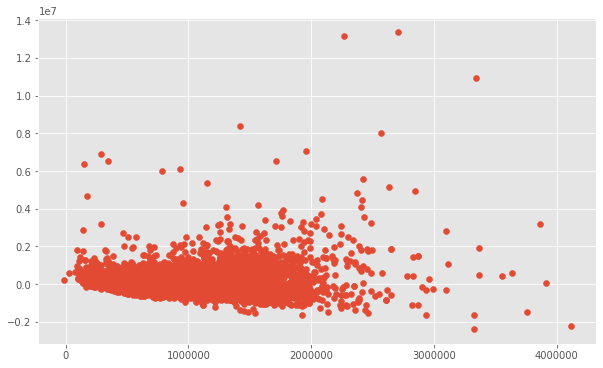

In [10]:
fsm_resids = fsm.resid
y_hat = fsm.predict()
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_hat, fsm_resids);

A pretty good cluster on the left, but we lose it as the numbers get bigger.

## check normality with Q-Q plot

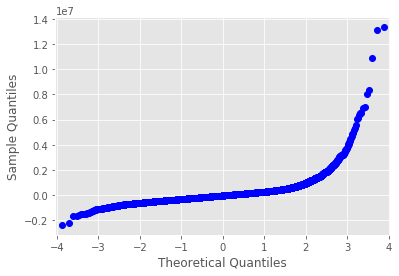

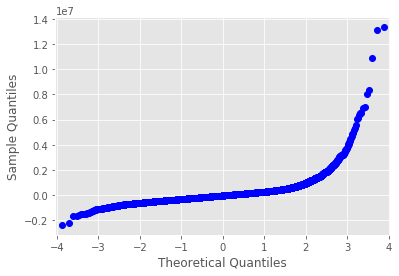

In [11]:
sm.qqplot(fsm_resids)

This line is pretty wavy here.

## check normality with Jarque Bera test

In [12]:
name = ['JB', 'Prob', 'Skew', 'Kurtosis']
test = sms.jarque_bera(fsm.resid)
list(zip(name, test))

[('JB', 12404873.130185945),
 ('Prob', 0.0),
 ('Skew', 6.728745246449707),
 ('Kurtosis', 128.0960031716819)]

None of this is looking very useful

### Let's try do drop some outliers 

let's remove elements with a z-score outsize of [-3,3]

In [17]:
from scipy import stats
ssm_df = fsm_df[(np.abs(stats.zscore(fsm_df)) < 3).all(axis=1)]

In [18]:
#How many values have we got left?
#We started with 19264
ssm_df.shape[0]

18360

We removed 904 outliers

In [20]:
formula = 'SalePrice ~ SqFtTotLiving'
ssm = ols(formula=formula, data=ssm_df).fit()

In [21]:
ssm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                 1.116e+04
Date:                Fri, 19 Jun 2020   Prob (F-statistic):               0.00
Time:                        17:15:41   Log-Likelihood:            -2.5776e+05
No. Observations:               18360   AIC:                         5.155e+05
Df Residuals:                   18358   BIC:                         5.155e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.587e+05   5933.069     26.755      0.000    1.47e+05     1.7e+05
SqFtTotLiving   279.5570      2.646    105.664      0.000     274.371     284.743
==============================================================================
Omnibus:                     3717.266   Durbin-Watson:                   0.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9797.794
Skew:                           1.097   Prob(JB):                         0.00
Kurtosis:                       5.827   Cond. No.                     5.96e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.96e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Well the R^2 is down slightly to .378. Everything else has come down too.
p-value of 0.00 staring right at me tho

## Check homoscedasticity again

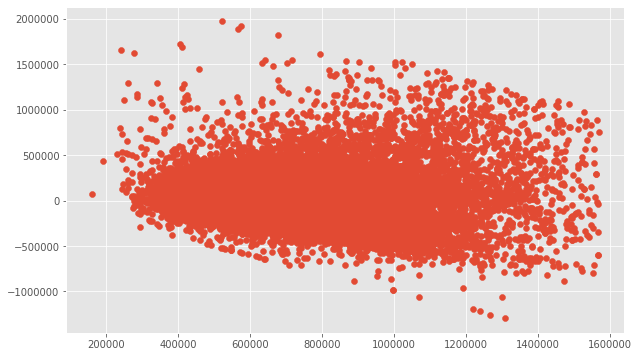

In [22]:
ssm_resids = ssm.resid
y_hat = ssm.predict()
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_hat, ssm_resids);

That actually looks pretty good

## check normality with Q-Q plot again

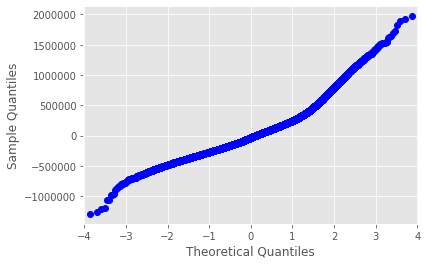

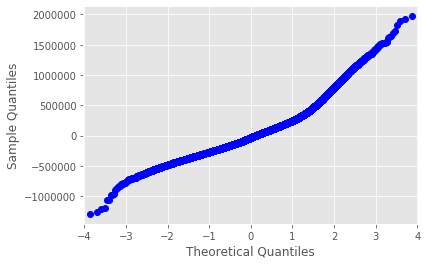

In [23]:
sm.qqplot(ssm_resids)

This line is better. A bit of a wave, but not terrible

## check normality with Jarque Bera test again

In [24]:
name = ['JB', 'Prob', 'Skew', 'Kurtosis']
test = sms.jarque_bera(ssm.resid)
list(zip(name, test))

[('JB', 9797.79396743444),
 ('Prob', 0.0),
 ('Skew', 1.0969964270239574),
 ('Kurtosis', 5.827360813555015)]

JB number came down. Skew came down. Kurtosis under 6, ok.

### Let's iterate and see what happens

In [30]:
#instantiate linear regression object
lr = LinearRegression()

#split data into target and features
y = ssm_df.SalePrice
X = ssm_df.drop('SalePrice', axis=1)

#call .fit from lr- feed it X and y
lr.fit(X,y)

#get R^2 (score)
score= lr.score(X,y)

beta = lr.coef_
intercept = lr.intercept_

print(f' Rsquared is {score}. Beta is {beta}. Intercept is {intercept}.')

 Rsquared is 0.3781767726250903. Beta is [279.55695311]. Intercept is 158738.4665317844.


That matches what we got above.

### Now let's see what happens if we add a porch to the mix

In [36]:
tsm_df = df[["SalePrice", "SqFtTotLiving", "SqFtOpenPorch"]].copy()
tsm_df.dropna(inplace=True)
formula = 'SalePrice ~ SqFtTotLiving+SqFtOpenPorch'
tsm = ols(formula=formula, data=tsm_df).fit()

In [32]:
tsm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     6010.
Date:                Fri, 19 Jun 2020   Prob (F-statistic):               0.00
Time:                        17:38:52   Log-Likelihood:            -2.7198e+05
No. Observations:               18807   AIC:                         5.440e+05
Df Residuals:                   18804   BIC:                         5.440e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -4814.7501   8248.006     -0.584      0.559    -2.1e+04    1.14e+04
SqFtTotLiving   365.4999      3.722     98.188      0.000     358.204     372.796
SqFtOpenPorch   233.8186     24.050      9.722      0.000     186.677     280.960
==============================================================================
Omnibus:                    24109.638   Durbin-Watson:                   1.112
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12393291.089
Skew:                           6.705   Prob(JB):                         0.00
Kurtosis:                     128.042   Cond. No.                     5.78e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
tsm.pvalues

Intercept        5.593974e-01
SqFtTotLiving    0.000000e+00
SqFtOpenPorch    2.742044e-22
dtype: float64

ssm_resids = ssm.resid
y_hat = ssm.predict()
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_hat, ssm_resids);

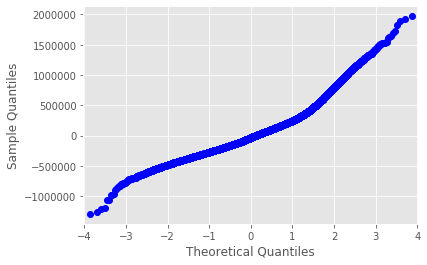

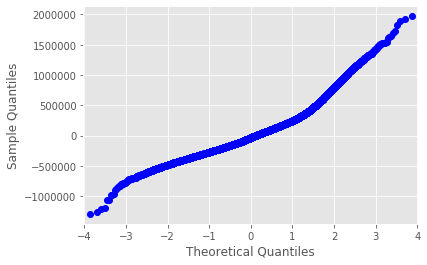

In [38]:
sm.qqplot(ssm_resids)

#instantiate linear regression object
lr = LinearRegression()

#split data into target and features
y = tsm_df.SalePrice
X = tsm_df.drop('SalePrice', axis=1)

#call .fit from lr- feed it X and y
lr.fit(X,y)

#get R^2 (score)
score= lr.score(X,y)

beta = lr.coef_
intercept = lr.intercept_

print(f' Rsquared is {score}. Beta is {beta}. Intercept is {intercept}.')

In [40]:
Another one the accepts the null?

Object `null` not found.


Another one the accepts the null?